In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import ArrowStyle
from pathlib import Path


import corneto as cnt
from corneto.backend import PicosBackend
cnt.__version__

'0.9.0-alpha.5'

In [2]:
print(f"Default solver is {cnt.DEFAULT_SOLVER} (using {str(cnt.DEFAULT_BACKEND)})")

Default solver is gurobi (using CVXPY Backend)


## Basic data manipulation

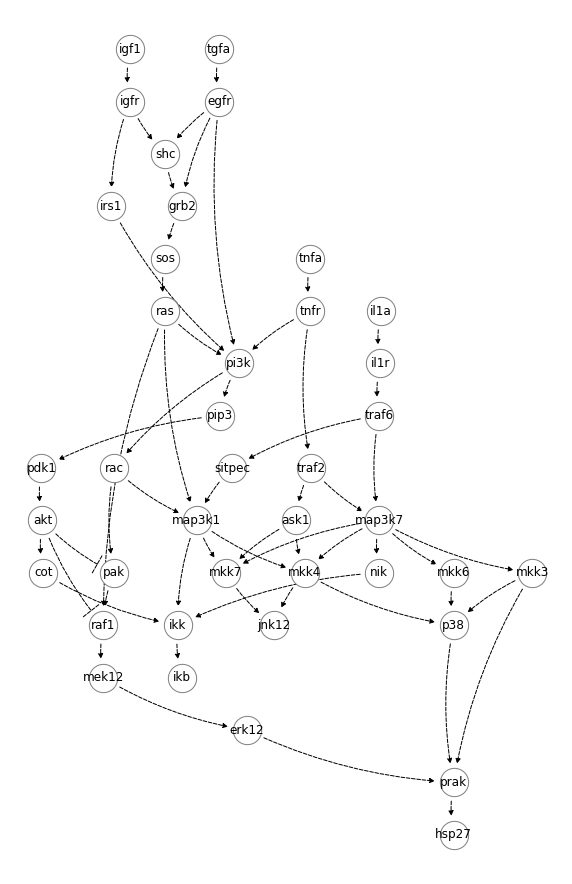

In [3]:
rn = cnt.ReNet.from_sif('../../tests/sif/PKN-LiverDREAM.sif')
rn.plot(figsize=(10, 16));

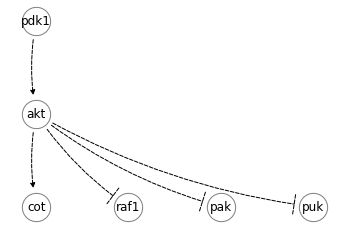

In [4]:
n0 = rn.select(['akt'])
n0.add_reaction('r1', {'akt': -1, 'puk': 1}, value=-1, inplace=False).plot();

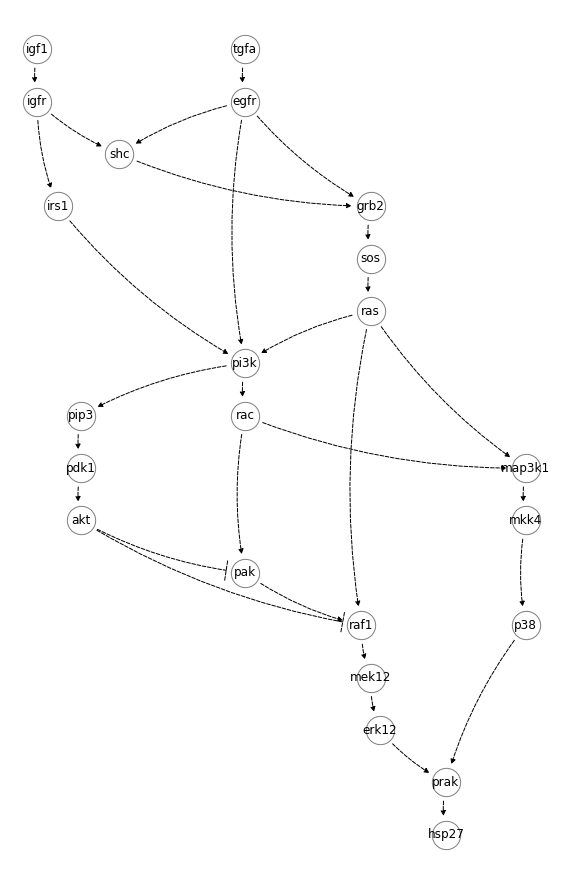

In [5]:
rn.prune(['tgfa', 'igf1'], ['hsp27']).plot(figsize=(10, 16));

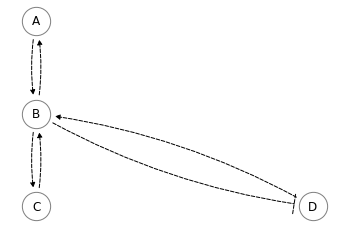

In [6]:
# Create a biochemical network from a dataframe
df_toy = pd.DataFrame({'source':      ['A', 'B', 'B', 'C', 'B', 'D'], 
                       'interaction': [ 1,   1,   1,   1,  -1,   1 ], 
                       'target':      ['B', 'A', 'C', 'B', 'D', 'B']})
rows = [(r.source, r.interaction, r.target) for (i, r) in df_toy.iterrows()]
cnt.ReNet.from_sif(rows).plot();

## CARNIVAL single/multi-condition

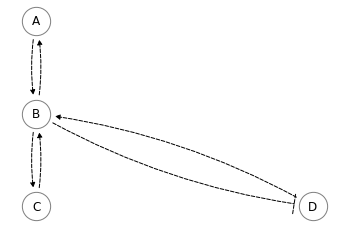

In [7]:
rn = cnt.ReNet.from_sif(rows)
rn.plot();

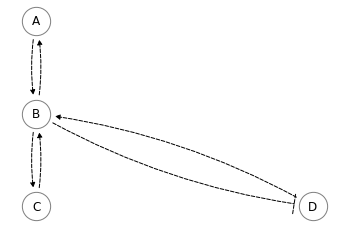

In [8]:
# Provisional impl of a more efficient ReNet
# NOTE: ReNet will be rewritten in next versions
from corneto._core import GReNet
rn = GReNet.from_renet(rn)
rn.plot();

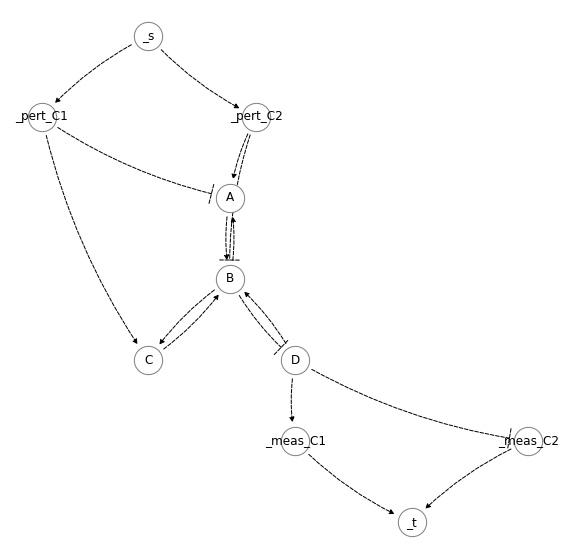

In [9]:
from corneto.methods.carnival import carnival_renet, carnival

data = {
    'C1': {
        'A': ('P', -5.1),
        'C': ('P', 1.2),
        'D': ('M', 0.5)
    },
    'C2': {
        'A': ('P', 1.1),
        'B': ('P', -0.5),
        'D': ('M', -1.1)
    }
}

# Transform the original network into a carnival network
rne = carnival_renet(rn, data)
rne.plot(figsize=(10, 10));

In [10]:
m = carnival(rne, data, l0_penalty_reaction=1e-4, dag=True)

In [11]:
# Show declared vars in carnival
m.symbols

{'_flow_rxn': Variable((18,)),
 '_flow_rxn_ipos': Variable((18,), boolean=True),
 'species_activated_C2': Variable((10,), boolean=True),
 'species_inhibited_C2': Variable((10,), boolean=True),
 'reaction_sends_activation_C2': Variable((18,), boolean=True),
 'reaction_sends_inhibition_C2': Variable((18,), boolean=True),
 'dag_layer_position_C2': Variable((10,)),
 'species_activated_C1': Variable((10,), boolean=True),
 'species_inhibited_C1': Variable((10,), boolean=True),
 'reaction_sends_activation_C1': Variable((18,), boolean=True),
 'reaction_sends_inhibition_C1': Variable((18,), boolean=True),
 'dag_layer_position_C1': Variable((10,))}

In [12]:
# Constraints of carnival
m.constraints

[Equality(Expression(AFFINE, UNKNOWN, (10,)), Constant(CONSTANT, ZERO, ())),
 Inequality(Expression(AFFINE, NONNEGATIVE, (18,))),
 Inequality(Variable((18,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, (2,)), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, (2,)), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Expression(AFFINE, NONNEGATIVE, (18,))),
 Inequality(Expression(AFFINE, NONNEGATIVE, (10,))),
 Inequality(Expression(AFFINE, NONNEGATIVE, (16,))),
 Inequality(Expression(AFFINE, NONNEGATIVE, (16,))),
 Inequality(Expression(AFFINE, UNKNOWN, (16,))),
 Inequality(Expression(AFFINE, UNKNOWN, (16,))),
 Inequality(Expression(AFFINE, NONNEGATIVE, (18,))),
 Inequality(

In [13]:
m.solve(verbosity=1).value

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Sep 15 01:01:50 PM: Your problem has 168 variables, 56 constraints, and 0 parameters.
(CVXPY) Sep 15 01:01:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 15 01:01:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 15 01:01:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 15 01:01:50 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Sep 15 01:01:50 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuf

1.0014

In [14]:
for i, c in enumerate(data.keys()):
    print(c, "loss:", m._objectives[i].value)

C1 loss: [0.]
C2 loss: [1.]


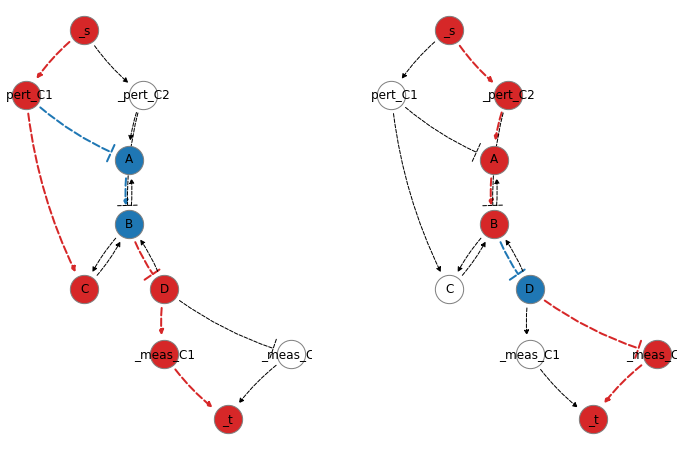

In [15]:
from corneto.methods.carnival import nx_style
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
rne.plot(custom_style=nx_style(rne, m, condition='C1'), ax=ax[0]);
rne.plot(custom_style=nx_style(rne, m, condition='C2'), ax=ax[1]);

## Carnival multi-timepoint [Proof of concept]

Experimental support for multi-timpoint. This will be simplified in the future.

In [16]:
from corneto.backend._base import HammingLoss
from corneto.methods.carnival import carnival_constraints, carnival_loss

dt = {
    't1': {'A': ('P', -5.1), 'C': ('P', 1.2), 'D': ('M', 0.5)},
    't2': {'A': ('P', -1.1), 'C': ('P', 1.2), 'B': ('M', 0.1), 'D': ('M', -1.1)}
}
dt

{'t1': {'A': ('P', -5.1), 'C': ('P', 1.2), 'D': ('M', 0.5)},
 't2': {'A': ('P', -1.1), 'C': ('P', 1.2), 'B': ('M', 0.1), 'D': ('M', -1.1)}}

In [17]:
t1 = {'CTP': dt['t1']}
t2 = {'CTP': dt['t2']}

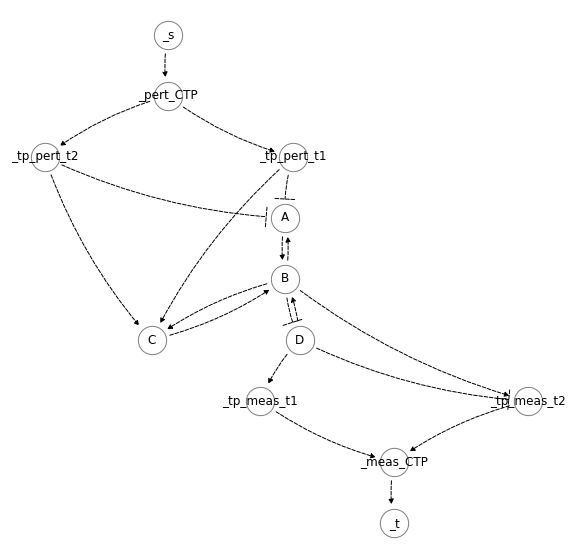

In [18]:
# We provide conditions_as_timepoints to build a different network for multi timpoints
rne = carnival_renet(rn, dt, conditions_as_timepoints=True)
rne.plot(figsize=(10, 10));

In [19]:
# This will be improved in future versions
problem_t1 = carnival_constraints(rne)
p_loss1 = carnival_loss(rne, t1, problem_t1)
m1 = problem_t1 + p_loss1
m1.solve(verbosity=1);
print(m1.objectives[0].value)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Sep 15 01:01:53 PM: Your problem has 120 variables, 30 constraints, and 0 parameters.
(CVXPY) Sep 15 01:01:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 15 01:01:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 15 01:01:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 15 01:01:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Sep 15 01:01:53 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuf

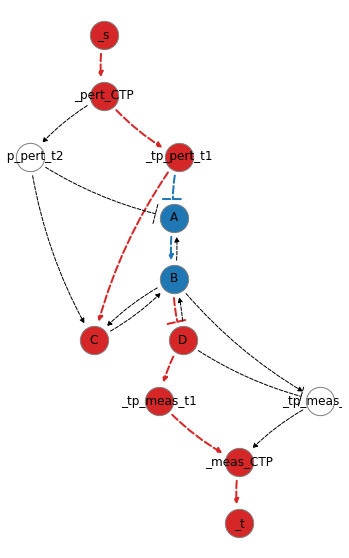

In [20]:
rne.plot(custom_style=nx_style(rne, m1, condition='CTP'), figsize=(6, 10));

In [21]:
# Solve the next timepoint. We get the reference solution of time point 1
ref = m1.symbols['reaction_sends_activation_CTP'].value + m1.symbols['reaction_sends_inhibition_CTP'].value
ref

array([1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0.])

In [22]:
# Solve second timepoing. The loss now is using the data of the timepoint t2.
problem_t2 = problem_t1 + carnival_loss(rne, t2, problem_t1)
# We want to add a penalty to minimize the distance of this solution with previous one (ref). We get the expression
# that is going to be compared against ref. In this case is R_activation + R_inhibition, which is 1 if reaction is selected
# and 0 if it's not.
candidate = problem_t2.symbols['reaction_sends_activation_CTP'] + problem_t2.symbols['reaction_sends_inhibition_CTP']
# We create the problem by taking the normal carnival with loss with respect to t2 + hamming distance between ref. and new sol.
m2 = problem_t2 + HammingLoss(ref, candidate, penalty=0.1)
m2.solve(verbosity=1);
print(m2.objectives[0].value, m2.objectives[1].value)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Sep 15 01:01:54 PM: Your problem has 120 variables, 30 constraints, and 0 parameters.
(CVXPY) Sep 15 01:01:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 15 01:01:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 15 01:01:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 15 01:01:54 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Sep 15 01:01:54 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuf

In [23]:
ref2 = m2.get_symbol('reaction_sends_activation_CTP').value + m2.get_symbol('reaction_sends_inhibition_CTP').value
ref2

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 0.])

In [24]:
# Verify the hamming distance
sum(abs(ref - ref2))

3.0

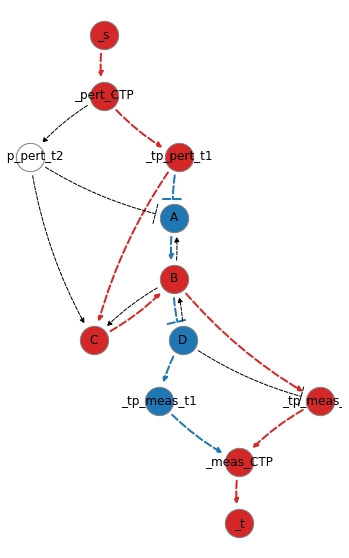

In [25]:
rne.plot(custom_style=nx_style(rne, m2, condition='CTP'), figsize=(6, 10));